## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum - `np.argmin`.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

In [50]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/'
fileName = 'jet.bmp'
if not os.path.exists(fileName) :
    r = requests.get(url + fileName, allow_redirects=True)
    open(fileName, 'wb').write(r.content)

### 1

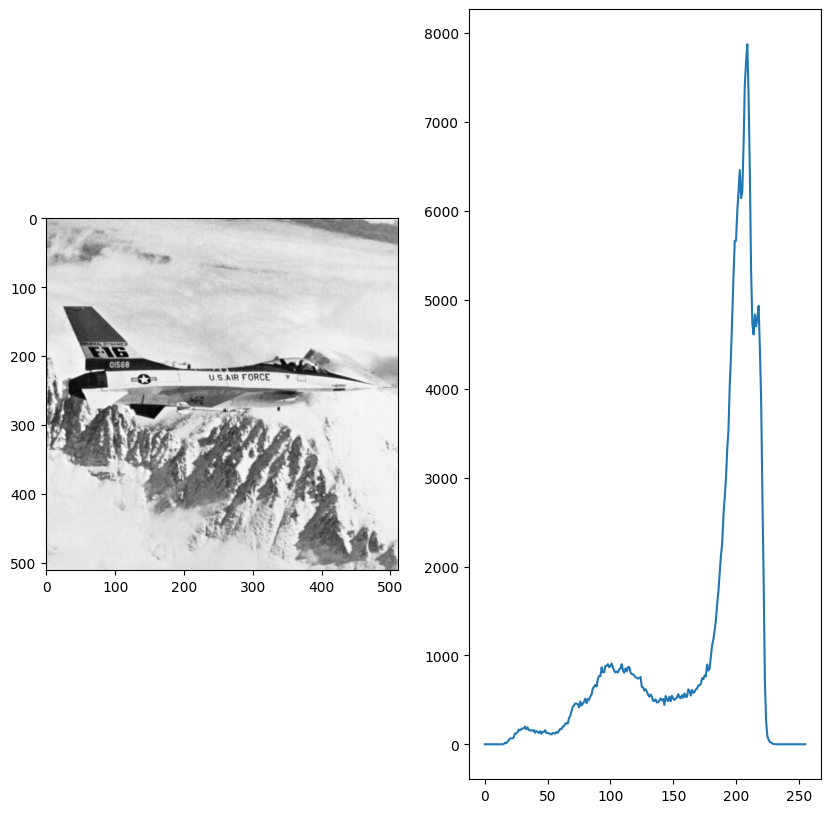

In [51]:
jet_img = cv2.imread(fileName, cv2.IMREAD_GRAYSCALE)
jet_hist = cv2.calcHist([jet_img], [0], None, [256], [0,256])
jet_hist_cum = np.cumsum(jet_hist)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(jet_img, cmap='gray')
plt.subplot(1,2,2)
plt.plot(jet_hist)
plt.show()

### 2 & 3

In [52]:
# Brightness from histogram = (number of bars * bar height) / (image width * image height) 
brightness = 0
for i in range(256):
    brightness += i * jet_hist[i]
brightness /= jet_img.shape[0] * jet_img.shape[1]
brightness = int(np.floor(brightness))
print("Average brightness: ", brightness)


Average brightness:  178


/tmp/ipykernel_565/511874325.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  brightness = int(np.floor(brightness))


### 4

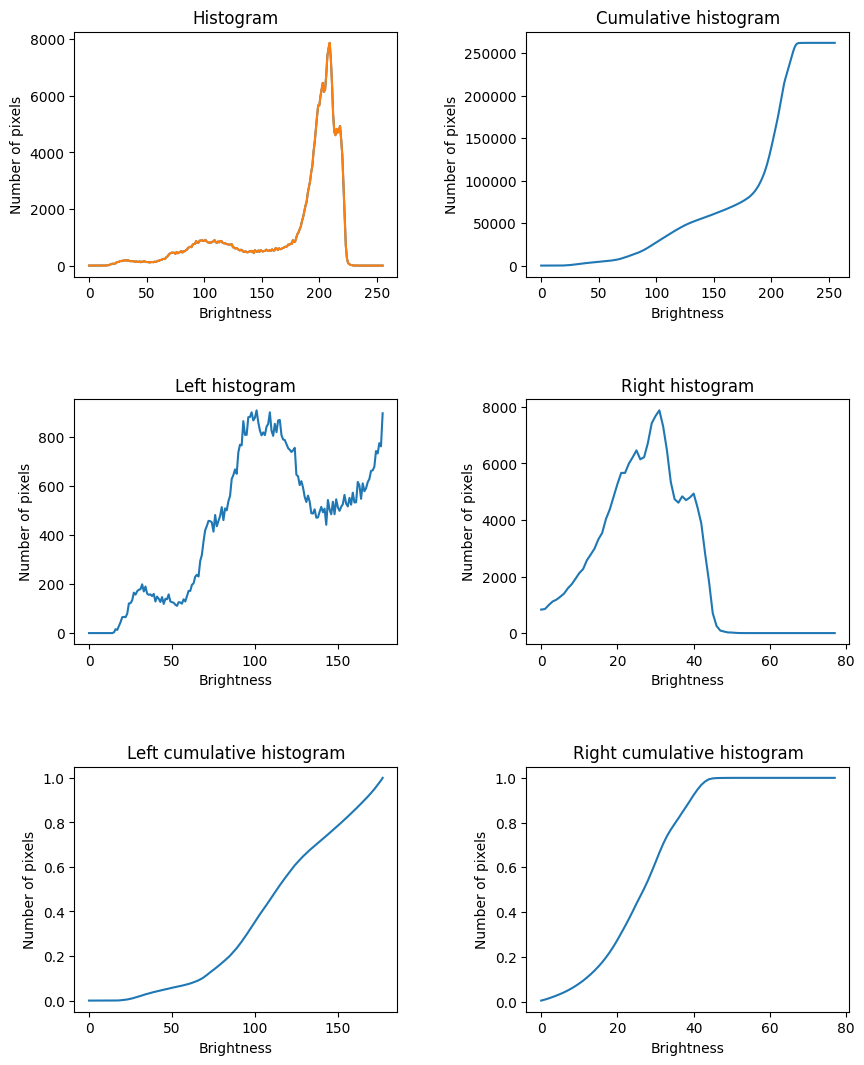

In [53]:
jet_hist_left = jet_hist[:brightness]
jet_hist_right = jet_hist[brightness:]
jet_hist_left_cum = np.cumsum(jet_hist_left)
jet_hist_right_cum = np.cumsum(jet_hist_right)
# Normalizing each histogram by dividing by max value
jet_hist_left_cum /= jet_hist_left_cum.max()
jet_hist_right_cum /= jet_hist_right_cum.max()

# Plot
fig, axs = plt.subplots(3, 2, figsize=(10,10))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
axs[0,0].plot(jet_hist)
for i, hist in enumerate([(jet_hist, "Histogram"), (jet_hist_cum, "Cumulative histogram"), (jet_hist_left, "Left histogram"), (jet_hist_right, "Right histogram"), (jet_hist_left_cum, "Left cumulative histogram"), (jet_hist_right_cum, "Right cumulative histogram")]):
    axs[i//2, i%2].plot(hist[0])
    axs[i//2, i%2].set_title(hist[1])
    axs[i//2, i%2].set_xlabel("Brightness")
    axs[i//2, i%2].set_ylabel("Number of pixels")
plt.show()


### 5

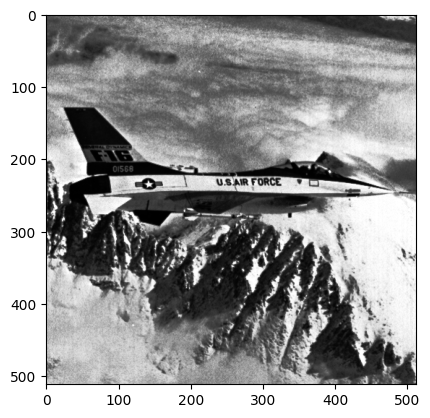

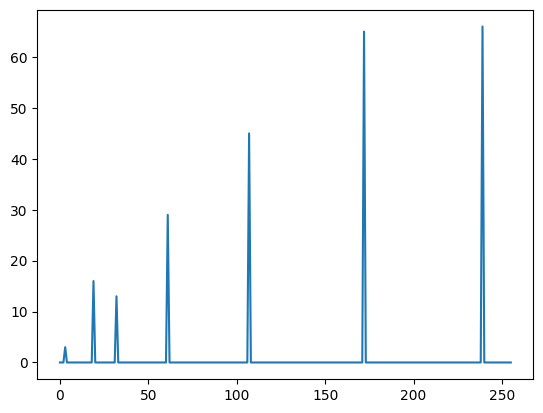

In [54]:
jet_hist_left_cum = jet_hist_left_cum * jet_hist_cum[brightness]
jet_hist_right_cum = jet_hist_right_cum * (jet_hist_cum[-1] - jet_hist_cum[brightness]) + jet_hist_cum[brightness]
jet_hist_cum = np.concatenate((jet_hist_left_cum, jet_hist_right_cum))

img_lut = cv2.LUT(jet_img, jet_hist_cum)

# Plot
plt.imshow(img_lut, cmap='gray')
plt.show()
plt.plot(cv2.calcHist([img_lut], [0], None, [256], [0,256]))
plt.show()


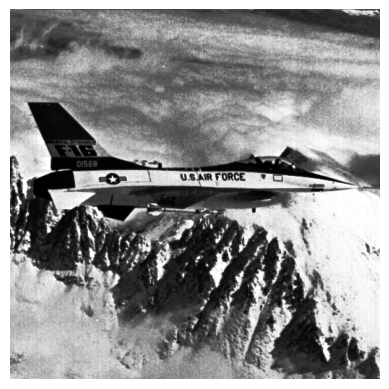

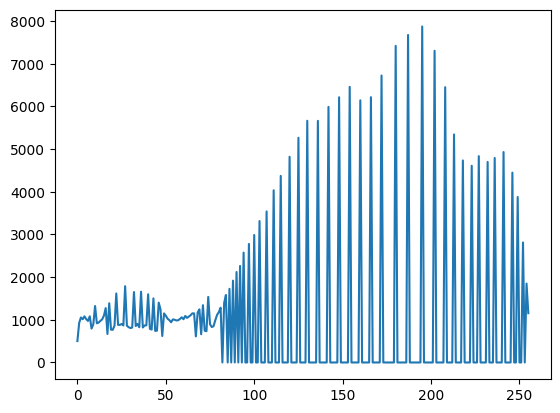

In [55]:
# Compare with HE
img_he = cv2.equalizeHist(jet_img)
plt.imshow(img_he, cmap='gray')
plt.axis("off")
plt.show()

plt.plot(cv2.calcHist([img_he], [0], None, [256], [0,256]))
plt.show()